# Финальное задание модуля EDA-4 #

## Популярные статистические тесты в Python ##

Описание задания приведено в файле [README.md](README.md)

In [1]:
import pandas as pd
from scipy.stats import shapiro, normaltest, pearsonr
# from scipy.stats import ttest_ind
# from numpy.random import rand
# from scipy.stats import spearmanr
from scipy.stats import f_oneway
# from statsmodels.stats import weightstats
# from statsmodels.stats.proportion import proportions_ztest

### Исходные массивы данных ###

In [2]:
petersburg = [0.0974, 0.1352, 0.0817, 0.1016, 0.0968, 0.1064, 0.105]
magadan = [0.1033, 0.0915, 0.0781, 0.0685, 0.0677, 0.0697, 0.0764, 0.0689]

### 1) Объединение двух массивов в DataFrame ###

In [3]:
petersburg_ser = pd.Series(data=petersburg, dtype=float, name='petersburg')
magadan_ser = pd.Series(data=magadan, dtype=float, name='magadan')
main_df = pd.DataFrame(data={'petersburg': petersburg_ser, 'magadan': magadan_ser})
display(main_df)
display(main_df.info())
display(main_df.describe())

,petersburg,magadan
0,0.0974,0.1033
1,0.1352,0.0915
2,0.0817,0.0781
3,0.1016,0.0685
4,0.0968,0.0677
5,0.1064,0.0697
6,0.1050,0.0764
7,NaN,0.0689


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   petersburg  7 non-null      float64
 1   magadan     8 non-null      float64
dtypes: float64(2)
memory usage: 256.0 bytes


None

,petersburg,magadan
count,7.000000,8.000000
mean,0.103443,0.078012
std,0.016209,0.012945
min,0.081700,0.067700
25%,0.097100,0.068800
50%,0.101600,0.073050
75%,0.105700,0.081450
max,0.135200,0.103300


В данных по Санкт-Петербургу не хватает данных. Можно в отдельном датафрейме заполнить пустые ячейки медианным значением.

In [25]:
full_df = main_df.copy()
full_df['petersburg'].fillna(round(full_df['petersburg'].median(), 4), inplace=True)
display(full_df)

,petersburg,magadan
0,0.0974,0.1033
1,0.1352,0.0915
2,0.0817,0.0781
3,0.1016,0.0685
4,0.0968,0.0677
5,0.1064,0.0697
6,0.1050,0.0764
7,0.1016,0.0689


### 2) Тесты на нормальное распределение ##

Для эксперимента можно провести как тест Шапиро-Уилка, так и тест Д'Агостино.
Итак, тест Шапиро-Уилка:

In [41]:
def shapiro_test(data_dict):
    H0 = 'распределение нормальное'
    H1 = 'распределение не является нормальным'
    alpha = 0.1
    for city_ in data_dict.keys():
        stat, p_val = shapiro(data_dict[city_])
        if p_val > alpha:
            print(f'{city_}: p-value = {round(p_val, 3)}, значит {H0}')
        else:
            print(f'{city_}: p-value = {round(p_val, 3)}, значит {H1}')

shapiro_test({'Санкт-Перербург': petersburg, 'Магадан': magadan})

Санкт-Перербург: p-value = 0.242, значит распределение нормальное
Магадан: p-value = 0.036, значит распределение не является нормальным


Тест Д'Агостино требует минимум 8 измерений, поэтому для Санкт-Петербурга можно попробовать данные с добавленным медианным значением из **`full_df`** в качестве недостающего.

Для наглядности можно дополнительно посмотреть, насколько результат может исказиться при такой добавке:

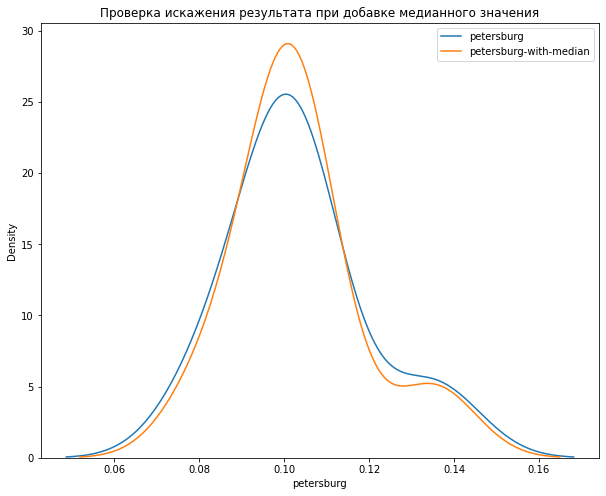

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Проверка искажения результата при добавке медианного значения')
sns.kdeplot(petersburg, ax=ax1, label='petersburg')
sns.kdeplot(full_df['petersburg'], ax=ax1, label='petersburg-with-median')
plt.legend();

Видно, что добавка медианного значения не сильно влияет на форму распределения плотности вероятности, которое заметно отличается от нормального.

Итак, тест Д'Агостино:

In [44]:
def dagostino_test(data_dict):
    H0 = 'распределение нормальное'
    H1 = 'распределение не является нормальным'
    alpha = 0.1
    for city_ in data_dict.keys():
        stat, p_val = normaltest(data_dict[city_])
        if p_val > alpha:
            print(f'{city_}: p-value = {round(p_val, 3)}, значит {H0}')
        else:
            print(f'{city_}: p-value = {round(p_val, 3)}, значит {H1}')

dagostino_test({'Санкт-Перербург': full_df['petersburg'], 'Магадан': magadan})

Санкт-Перербург: p-value = 0.035, значит распределение не является нормальным
Магадан: p-value = 0.154, значит распределение нормальное


В обоих тестах одна из групп данных не проходит тест на нормальность. Следовательно, надо использовать непараметрические тесты.

Размеры мидий являются непрерывными переменными. Значит проведём параметрический тест на корелляцию Пирсона.

### 3) Тест на корреляцию и его обоснование ###

- Корреляция Пирсона работает для нормального распределения количественных данных, поэтому её не используем.

Тест Пирсона стандартным методом **Pandas** продублируем методом из **ScyPy**. Заодно убедимся, что они равнозначны.

In [27]:
main_df.corr()

,petersburg,magadan
petersburg,1.000000,0.244845
magadan,0.244845,1.000000


In [28]:
corr, p = pearsonr(main_df['petersburg'], main_df['magadan'], alternative='two-sided')
print(f'Коэффициент корелляции = {round(corr, 6)}')

Коэффициент корелляции = 0.244845


### 4) Вывод по гипотезе ###

1. Распределение по обоим наборам данных принимаем нормальным. Выглядит, как подгонка результатов, и тем не менее. На таком малом объёме измерений.
2. Коэффициент корелляции <&nbsp;0,3. То есть связь очень слабая или отсутствует.

### 5) Тест на сравнение выборок ###

In [32]:
stat, p = f_oneway(petersburg, magadan)
print(f'p = {p}')

p = 0.004940324868384317


In [45]:
from scipy.stats import mannwhitneyu
mannwhitneyu(petersburg, magadan)

MannwhitneyuResult(statistic=51.0, pvalue=0.005905205905205905)

### 6) Обоснование выбоа теста на сравнение ###

### 7) Вывод по гипотезе ###

Является ли найденная разность средних значений статистически значимой?

Мы отвергаем нулевую гипотезу. Есть значимая разница между средним размером раковины мидий в трех разных местах.